# Layers

In [1]:
import numpy as np
from tqdm import tqdm

In [2]:
random_seed = 2764763
np.random.seed(random_seed)

In [3]:
class InputLayer():
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.shape = (self.input_dim,)
        
    def forward(self, input_data):
        self.input = input_data
        self.output = self.input
        return self.output

In [4]:
class DenseLayer():
    def __init__(self, input_dim, output_dim, activation, activation_grad):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.shape = (self.input_dim, self.output_dim)

        self.weights = np.random.rand(input_dim, output_dim) - 0.5
        self.grad = np.zeros_like(self.weights)

        self.activation = activation
        self.activation_grad = activation_grad

        self.is_output = False

    def forward(self, input_data):
        self.input = input_data

        # Multiply the weights and the input
        # Let z be the unactivated output (without the bias)
        self.z = np.matmul(np.transpose(self.weights), self.input)
        # Apply the activation
        self.output = self.activation(self.z)
        # Add the bias
        if self.is_output == False:
            self.output = np.concatenate([np.array([1.0], ndmin=2), self.output], axis=0)
        return self.output

    def backward(self, input_data, weights_data):
        self.delta = input_data

        if self.is_output == True:
            # Just make delta the error if final layer
            self.delta = self.output - self.delta

        else:
            # Matrix multiplication
            self.delta = np.matmul(weights_data, self.delta)
            # Remove the bias
            self.delta = np.delete(self.delta, 0, axis=0)
            # "Undo" the activation
            self.delta = self.delta * self.activation_grad(self.z)

In [5]:
class NeuralNetwork():
    def __init__(self, loss, learning_rate):
        self.layers = []
        self.trained = False

        self.loss = loss

        self.learning_rate = learning_rate

    def add(self, layer):
        if len(self.layers) > 0:
            self.layers[-1].is_output = False
        self.layers.append(layer)
        self.layers[-1].is_output = True

    def predict(self, X):
        if self.trained == False:
            print("Model not trained!")
        else:
            self.X_pred = X
            self.y_pred = []

            num_examples = X.shape[0]

            for i in range(num_examples):
                x = np.expand_dims(np.transpose(X[i, :]), axis=1)
                h = x.copy()

                for layer in self.layers:
                    h = layer.forward(h)

                self.y_pred.append(h)

            self.y_pred = np.array(self.y_pred, ndmin=2)

            return self.y_pred
            

    def fit(self, X, y, val_data=None, batch_size=32, epochs=10):
        self.X = X
        self.y = y
        self.val_data = val_data
        self.batch_size = batch_size
        self.epochs = epochs
        self.history = {'loss': [], 'val_loss': []}

        num_examples = X.shape[0]

        for epoch in range(self.epochs):
            total_loss = 0
            
            for i in range(num_examples):
                x = np.expand_dims(np.transpose(X[i, :]), axis=1)

                # Feed forward
                h = x.copy()
                for layer in self.layers:
                    h = layer.forward(h)
                
                training_loss = self.loss(self.y[i], h)
                total_loss += training_loss

                # Backpropagation
                # Accumulate layer gradients
                for l in reversed(range(len(self.layers))):
                    
                    if l > 0:
                        if self.layers[l].is_output == True:
                            self.layers[l].backward(self.y[i], weights_data=None)

                        else:
                            self.layers[l].backward(self.layers[l + 1].delta, weights_data=self.layers[l + 1].weights)

                        self.layers[l].grad += np.matmul(self.layers[l - 1].output, np.transpose(self.layers[l].delta))

            # Get average and update weights
            for l in reversed(range(len(self.layers))):
                    if l > 0:
                        self.layers[l].grad /= num_examples
                        self.layers[l].weights -= self.learning_rate * self.layers[l].grad

            mean_loss = total_loss / num_examples

            if self.val_data == None:
                print("Epoch", epoch)
                print("Training Loss:", mean_loss)
            else:
                val_X = self.val_data[0]
                val_y = self.val_data[1]
                num_val_examples = val_X.shape[0]
                total_val_loss = 0
                for i in range(num_val_examples):
                    val_x = np.expand_dims(np.transpose(val_X[i, :]), axis=1)
                    val_h = val_x.copy()
                    for layer in self.layers:
                        val_h = layer.forward(val_h)
                    val_loss = self.loss(val_y[i], h)
                    total_val_loss += val_loss
                mean_val_loss = total_val_loss / num_val_examples

                print("Epoch", epoch)
                print("Training Loss:", mean_loss, "  Validation Loss:", mean_val_loss)
                self.history['loss'].append(mean_loss)
                self.history['val_loss'].append(mean_val_loss)

        self.trained = True
        
        self.history['loss'] = np.squeeze(self.history['loss'])
        self.history['val_loss'] = np.squeeze(self.history['val_loss'])
        
        return self.history

# Losses

In [6]:
# y is true label value, h is prediction
def binary_crossentropy(y, h):
    return y * (-np.log(h)) + (1 - y) * (-np.log(1 - h))

# Activations

In [7]:
def relu(z):
    return z * (z > 0)

# Cleaned up the relu gradient
# Nice explanation of why its value at 0 doesn't matter:
# https://www.quora.com/How-do-we-compute-the-gradient-of-a-ReLU-for-backpropagation
def relu_grad(z):
    return np.array(z > 0, dtype=np.int)

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Should be (sigmoid(z)) * (1 - sigmoid(z)), rather than (sigmoid(z)) * (sigmoid(1 - z))
def sigmoid_grad(z):
    # return sigmoid(z) * sigmoid(1-z)
    return sigmoid(z) * (1 - sigmoid(z))

In [9]:
def tanh(z):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

def tanh_grad(z):
    return 1 - (tanh(z) ** 2)

# Processing Data

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
data = pd.read_csv('/content/indian_liver_patient.csv')
original_data = data.copy()

## Missing Values

## Encoding

In [12]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

In [13]:
data['Albumin_and_Globulin_Ratio'] = data['Albumin_and_Globulin_Ratio'].fillna(data['Albumin_and_Globulin_Ratio'].mean())

In [14]:
data = binary_encode(data, 'Gender', 'Male')

Let's change the labels to 0, 1 instead of 1, 2

In [15]:
data = binary_encode(data, 'Dataset', 1)

In [16]:
data

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,1,0.5,0.1,500,20,34,5.9,1.6,0.37,0
579,40,1,0.6,0.1,98,35,31,6.0,3.2,1.10,1
580,52,1,0.8,0.2,245,48,49,6.4,3.2,1.00,1
581,31,1,1.3,0.5,184,29,32,6.8,3.4,1.00,1


In [17]:
y = data['Dataset'].copy()
X = data.drop('Dataset', axis=1).copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = np.expand_dims(np.array(y), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Training

In [19]:
X_train.shape

(326, 10)

In [20]:
y_train.shape

(326, 1)

In [21]:
model = NeuralNetwork(loss=binary_crossentropy, learning_rate=0.01)

model.add(InputLayer(input_dim=10))
model.add(DenseLayer(input_dim=10, output_dim=64, activation=relu, activation_grad=relu_grad))
model.add(DenseLayer(input_dim=65, output_dim=64, activation=relu, activation_grad=relu_grad))
model.add(DenseLayer(input_dim=65, output_dim=1, activation=sigmoid, activation_grad=sigmoid_grad))

In [22]:
for layer in model.layers:
    try:
        print(layer.weights.shape)
        print(layer.is_output)
    except:
        pass

(10, 64)
False
(65, 64)
False
(65, 1)
True


In [23]:
val_data = (X_val, y_val)

In [24]:
batch_size=32
epochs = 200

history = model.fit(X_train, y_train, val_data=val_data, batch_size=batch_size, epochs=epochs)

Epoch 0
Training Loss: [[2.04875419]]   Validation Loss: [[2.67606518]]
Epoch 1
Training Loss: [[1.85369474]]   Validation Loss: [[2.42095568]]
Epoch 2
Training Loss: [[1.67756929]]   Validation Loss: [[2.1821444]]
Epoch 3
Training Loss: [[1.51959515]]   Validation Loss: [[1.96154604]]
Epoch 4
Training Loss: [[1.37875078]]   Validation Loss: [[1.75906682]]
Epoch 5
Training Loss: [[1.25405991]]   Validation Loss: [[1.57545782]]
Epoch 6
Training Loss: [[1.14567665]]   Validation Loss: [[1.41190626]]
Epoch 7
Training Loss: [[1.05316566]]   Validation Loss: [[1.26920337]]
Epoch 8
Training Loss: [[0.97625775]]   Validation Loss: [[1.14789321]]
Epoch 9
Training Loss: [[0.91440123]]   Validation Loss: [[1.04674582]]
Epoch 10
Training Loss: [[0.86649865]]   Validation Loss: [[0.96477337]]
Epoch 11
Training Loss: [[0.83042924]]   Validation Loss: [[0.89976204]]
Epoch 12
Training Loss: [[0.80346382]]   Validation Loss: [[0.84861684]]
Epoch 13
Training Loss: [[0.78320025]]   Validation Loss: [[0.

In [25]:
np.argmin(history['val_loss'])

66

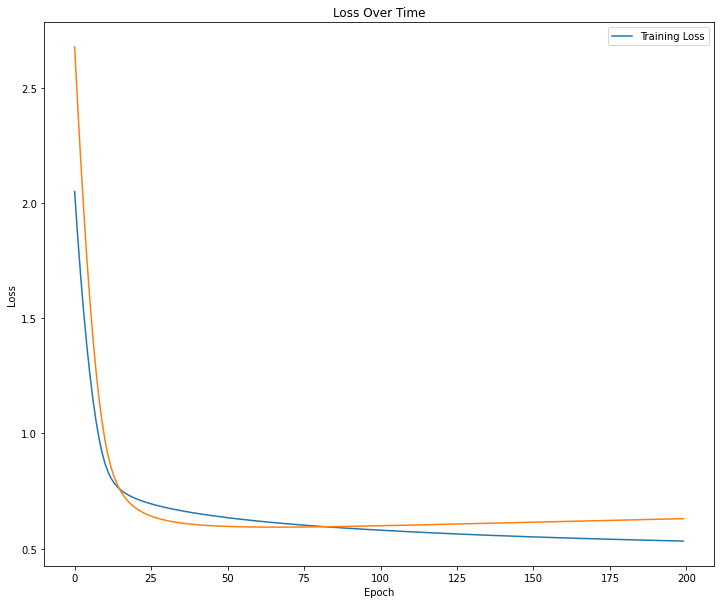

In [26]:
epochs_range = range(epochs)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.plot(
    epochs_range,
    history['loss'],
    label="Training Loss"
)

plt.plot(
    epochs_range,
    history['val_loss'],
)

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.title("Loss Over Time")

plt.show()

In [27]:
np.argmin(history['val_loss'])

66

In [28]:
y_pred = model.predict(X_test)
y_pred = np.array(y_pred > 0.5, dtype=np.int)

y_pred = np.squeeze(y_pred)
y_true = np.squeeze(y_test)

In [29]:
# Getting accuracy

results = (y_true == y_pred)
print(np.mean(results))

0.72
